In [1]:
from database.strategy import Strategy
from database.sec import SEC
from database.market import Market
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import math

In [18]:
# Loading Databases
strat_db = Strategy("predictive_series_quarterly")
quarterly_db = Strategy("qrmfprc")
market = Market()
sec = SEC("sec")
reload = False

In [33]:
strat_db.connect()
sim = strat_db.retrieve_data("sim_tf")
strat_db.close()

In [19]:
quarterly_db.connect()
quarterly_sim = quarterly_db.retrieve_data("quarterly_sim")
quarterly_db.close()

In [20]:
quarterly_sim_columns = quarterly_sim.columns
qsc = [x for x in quarterly_sim_columns if "score" in x]
qcc = [x for x in quarterly_sim_columns if "classification_prediction" in x]
qrc = [x for x in quarterly_sim_columns if "regression_prediction" in x]

In [9]:
market.connect()
sp5 = market.retrieve_data("sp500")
market.close()

In [12]:
availability = []
start = datetime(2017,1,1)
end = datetime(2020,9,1)
for ticker in list(sp5["Symbol"]):
    ticker = ticker.replace(".","-")
    td = sim[(sim["ticker"]==ticker) & (sim["buy_date"]<=end)]
    try:
        availability.append({"ticker":ticker
                             ,"sell_date":end <= td.iloc[len(td)-1]["buy_date"]
                             ,"days":(td.iloc[len(td)-1]["buy_date"]- td.iloc[0]["buy_date"]).days
                            ,"records":len(td[td["buy_date"] <= end])
                            ,"pct":math.ceil(len(td[td["buy_date"] <= end])/(end - td.iloc[0]["buy_date"]).days * 100)})
    except Exception as e:
        continue
stuff = pd.DataFrame(availability)
sp5_tickers = list(stuff[(stuff["pct"] >= stuff["pct"].mode().item() - 1) | (stuff["pct"] <= stuff["pct"].mode().item() + 1)]["ticker"].values)

In [37]:
sim.rename({"buy_date":"date"},inplace=True,axis=1)

In [38]:
sim.iloc[0]

_id                     5f4e65f6fa942eb43578c88a
calculation_date             2016-01-04 00:00:00
shift                                          1
date                         2016-01-04 00:00:00
sell_date                    2016-01-05 00:00:00
buy_price                                127.956
sell_price                               128.513
prediction                               95.5055
predicteddailyreturn                   -0.226023
actualdailyreturn                     0.00434961
mape                                   0.0746912
ticker                                       MMM
Name: 0, dtype: object

In [27]:
quarterly_sim.columns

Index(['_id', 'date', 'ticker', 'adjclose', 'qmtd', 'passed',
       'quarterly_fundamental_classification_prediction',
       'quarterly_fundamental_classification_score',
       'quarterly_fundamental_regression_prediction',
       'quarterly_fundamental_regression_score',
       'quarterly_price_classification_prediction',
       'quarterly_price_classification_score',
       'quarterly_price_regression_prediction',
       'quarterly_price_regression_score'],
      dtype='object')

In [ ]:
def backtest(sim,score,include_past_features,trade_incentive,weekly_delta_req,ascending,seats):
    trades = []
    if not include_past_features:
        sim_columns = [x for x in sim.columns if "weekly" not in x]
    else:
        sim_columns = sim.columns
    sorted_column = "actualdailyreturn"
    sc = [x for x in sim_columns if "score" in x]
    sc.append("mape")
    cc = [x for x in sim_columns if "classification_prediction" in x]
    rc = [x for x in sim_columns if "regression_prediction" in x]
    classification = int(not trade_incentive)
    blacklist = pd.DataFrame([{"ticker":"ZZZZZ","start":datetime(2016,4,1),"end":datetime(2016,4,14)}])
    for i in range(seats):
        date = start
        while date <= end:
            if date.weekday() > 4:
                date = date + timedelta(days=7-date.weekday())
            blacklist_tickers = blacklist[(blacklist["start"] <= date) & (blacklist["end"] >= date)]["ticker"]
            taken = []
            for col in sc:
                sim = sim[sim[col] >= score]
            for col in cc:
                sim = sim[sim[col] == classification]
            todays_sim = sim[(~sim["ticker"].isin(blacklist_tickers)) & (sim["ticker"].isin(sp5_tickers))
                            & (sim["date"] == date)]
            if todays_sim.index.size >= 1:
                try:
                    offerings = todays_sim.sort_values(sorted_column,ascending=ascending)
                    trade = offerings.head(1)
                    sell_date = trade["date"].item()
                    sell_trades = sim[(sim["date"] > sell_date) & (sim["ticker"] == trade["ticker"].item())]
                    sell_trades = sell_trades.iloc[:5]
                    sell_trades["delta"] = (sell_trades["adjclose"] - trade["adjclose"].item()) / trade["adjclose"].item()
                    positive_trades = sell_trades[sell_trades["delta"] >= weekly_delta_req]
                    if positive_trades.index.size < 1:
                        sell_trade = sell_trades.tail(1)
                    else:
                        sell_trade = positive_trades.head(1)
                    try:
                        trade["sell_price"] = int(sell_trade["adjclose"].item())
                        trade["sell_date"] = sell_trade["date"].item()
                        trade["sell_delta"] = float(sell_trade["delta"].item())
                        trade["seat"] = i
                        blacklist = blacklist.append([{"ticker":trade["ticker"].item(),"start":trade["date"].item(),"end":sell_trade["date"].item()}])
                        trades.append(trade)
                        date = sell_date + timedelta(days=1)
                    except Exception as e:
                        print("packaging",str(e))
                        date = date + timedelta(days=1)
                except Exception as e:
                    print("offering",str(e))
                    date = date + timedelta(days=1)
            else:
                date = date + timedelta(days=1)
    return trades

In [11]:
end_date = sim["date"][len(sim["date"])-1]
start_date = sim["date"][0]
epoch = 0
epoch_dicts = []
trades = []
positions = 5
for d in tqdm(range(5,25,5)):
    delta = d/100
    for m in np.arange(5,55,10):
        mape = m /100
        for asc in [True,False]:
            epoch_dict = {"epoch":epoch,"delta_req":delta,"mape_req":mape,"asc":asc,"portfolio_days":(end_date-start_date).days}
            epoch_dicts.append(epoch_dict)
            buy_date = start_date
            while(buy_date <= end_date):
                try:
                    available = sim[(sim["date"] == buy_date) 
                            & (sim["prediction"] != 0) 
                            & (sim["predicteddailyreturn"] < -delta)
                           & (sim["mape"] < mape)]
                    offerings = available.sort_values("predicteddailyreturn",ascending=asc)
                    if len(offerings) < 1:
                        buy_date = buy_date + timedelta(days=1)
                        continue
                    trade = offerings.iloc[0]
                    trade["epoch"] = epoch
                    trades.append(trade)
                    buy_date = trade["sell_date"]
                    if buy_date > end_date:
                        break
                except Exception as e:
                    print(str(e))
                    continue
            epoch+=1

  0%|                                                                                                                                                                                | 0/4 [00:00<?, ?it/s]<ipython-input-11-02c9a80ecc74>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade["epoch"] = epoch
c:\users\eric\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [12]:
t = pd.DataFrame(trades)
e = pd.DataFrame(epoch_dicts)
t["daydelta"] = t["sell_date"] - t["date"]
t["days"] = [x.days for x in t["daydelta"]]
t["gains"] = t["actualdailyreturn"] * t["days"]
final = t.merge(e,on="epoch",how="left")

In [13]:
analysis = []
for epoch in epoch_dicts:
    epoch_t = final[final["epoch"] == epoch["epoch"]]
    initial = 100
    for gains in epoch_t["gains"]:
        initial = initial * (1 + gains)
    epoch["pv"] = initial
    epoch["trades"] = len(epoch_t)
    epoch["hpr"] = epoch_t["days"].mean()
    epoch["dailyreturn"] = epoch_t["actualdailyreturn"].mean()
    epoch["totalreturn"] = epoch_t["gains"].mean()
    epoch["winrate"]= len(epoch_t[epoch_t["actualdailyreturn"] > 0 ]) / len(epoch_t)
    analysis.append(epoch)

In [16]:
a = pd.DataFrame(analysis).sort_values("pv",ascending=False)

In [28]:
a

,epoch,delta_req,mape_req,asc,portfolio_days,pv,trades,hpr,dailyreturn,totalreturn,winrate
2,2,0.05,0.15,True,3467,6764.279724,1745,1.446991,0.001299,0.002807,0.528940
4,4,0.05,0.25,True,3467,5289.348407,2055,1.447689,0.001017,0.002356,0.527007
6,6,0.05,0.35,True,3467,4908.312910,2130,1.445540,0.000951,0.002255,0.524413
8,8,0.05,0.45,True,3467,4742.524509,2167,1.444393,0.000920,0.002203,0.524689
12,12,0.10,0.15,True,3467,3870.455353,1709,1.430661,0.001109,0.002511,0.528964
22,22,0.15,0.15,True,3467,3557.867361,1599,1.382114,0.001227,0.002599,0.526579
23,23,0.15,0.15,False,3467,3482.125576,1512,1.463624,0.001201,0.002732,0.528439
14,14,0.10,0.25,True,3467,3317.069712,1975,1.436456,0.000929,0.002181,0.527595
24,24,0.15,0.25,True,3467,3275.980780,1843,1.394466,0.001072,0.002300,0.524688
25,25,0.15,0.25,False,3467,3258.178612,1655,1.554683,0.001065,0.002541,0.526888


In [101]:
trades = t
trades["sell_weekday"] = [x.weekday() for x in trades["sell_date"]]
trades["buy_weekday"] = [x.weekday() for x in trades["date"]]
trades["sell_monthday"] = [x.day for x in trades["sell_date"]]
trades["buy_monthday"] = [x.day for x in trades["date"]]
trades["sell_yearday"] = [-(datetime(x.year,1,1) - x).days for x in trades["sell_date"]]
trades["buy_yearday"] = [-(datetime(x.year,1,1) - x).days for x in trades["date"]]
trades["hpr"] = trades["sell_date"] - trades["date"]
trades["days"] = [x.days for x in trades["hpr"]]
trades["sell_quarterday"] = [-(datetime(x.year,x.quarter*3-2,1) - x).days for x in trades["sell_date"]]
trades["buy_quarterday"] = [-(datetime(x.year,x.quarter*3-2,1) - x).days for x in trades["date"]]

In [131]:
col = "buy_yearday"
col2 = "sell_yearday"
g_sim = trades.groupby([col,col2]).mean().reset_index()
g_sim.sort_values("actualdailyreturn",ascending=False)[[col,col2,"buy_quarterday","actualdailyreturn"]].head(50).sort_values("buy_yearday",ascending=True)

,buy_yearday,sell_yearday,buy_quarterday,actualdailyreturn
23,6,9,6.000000,0.018672
93,20,21,20.000000,0.018214
95,20,23,20.000000,0.032314
109,23,24,23.000000,0.020105
148,30,31,30.000000,0.018159
200,39,42,39.000000,0.039489
216,42,45,42.000000,0.020421
260,50,53,50.000000,0.026707
305,58,61,58.000000,0.035185
351,66,70,66.000000,0.017971


,buy_weekday,sell_weekday,actualdailyreturn
20,4,0,0.003396
22,4,2,0.003044
5,1,0,0.002385
3,0,3,0.001874
2,0,2,0.001687
1,0,1,0.001659
7,1,2,0.001537
17,3,2,0.001518
0,0,0,0.001493
23,4,3,0.001479


In [64]:
trades.columns

Index(['_id', 'date', 'sell_date', 'buy_price', 'sell_price', 'prediction',
       'predicteddailyreturn', 'actualdailyreturn', 'mape', 'ticker', 'epoch',
       'daydelta', 'days', 'gains', 'sell_weekday', 'buy_weekday',
       'sell_monthday', 'buy_monthday', 'sell_yearday', 'buy_yearday'],
      dtype='object')

In [18]:
# from sklearn.preprocessing import Normalizer
# quarterly_sim = sim.groupby("quarter").mean()
# plt.plot(quarterly_sim["mape"])
# fig = plt.gcf()
# fig.set_size_inches(14,7)
# plt.show()

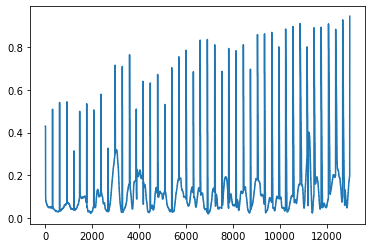

In [23]:
# ag = a.groupby("delta_req").mean()
plt.plot(sim["mape"])

In [26]:
sim["dayofmonth"] = [x.day for x in sim["date"]]

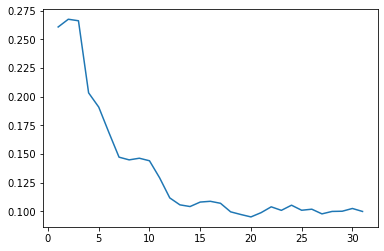

In [27]:
g_sim = sim.groupby("dayofmonth").mean()
plt.plot(g_sim["mape"])